## Accessibility to schools - KP, Pakistan

### Inputs
- Driving friction surface
- Gridded population
- School data

This notebook cleans the school data, and re-uses inputs from the previous health script (urban population, and travel time) to calculate rural pop. within 30 min. drive of schools

### Import libriaries

In [44]:
import sys, os
import rasterio

import pandas as pd
import geopandas as gpd
import numpy as np
import skimage.graph as graph

from rasterio.mask import mask
from rasterio import features
from shapely.geometry import box, Point, Polygon
from scipy.ndimage import generic_filter

# sys.path.append("../../../GOST_Urban")
# import src.UrbanRaster as urban

sys.path.append("/home/wb514197/Repos/INFRA_SAP")
sys.path.append('/home/wb514197/Repos/GOSTnets')
import infrasap.market_access as ma
import infrasap.rasterMisc as rMisc
from infrasap.misc import tPrint

import fiona
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#User records
# destinations = "/home/public/Data/COUNTRY/PAK/HEALTH/pakistan_health_facilities/Pakistan_Health_Facilities.shp"
iso3 = "PAK"
data_dir = "/home/wb514197/data/PAK"
out_folder = os.path.join(data_dir, "output")

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

### 1. Process and clean school data

In [5]:
schools_dir = os.path.join(data_dir, "schools")

In [6]:
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

In [7]:
res_list = []
for district in os.listdir(schools_dir):
    print(district)
    kmz = gpd.read_file(os.path.join(schools_dir, district))
    for idx, row in kmz.iterrows():
        table = pd.read_html(kmz.loc[idx].description)[1]
        table = table.transpose()
        table.columns = table.iloc[0]
        table = table.drop(axis=0, index=0)
        table.index = [idx]
        if idx==0:
            res = table.copy()
        else:
            res.loc[idx] = table.loc[idx]
    res_list.append(res)

Abbottabad.kmz
Bannu.kmz
Battagram.kmz
Bunner.kmz
Charsadda.kmz
Chitral.kmz
D.I. Khan.kmz
Dir Lower.kmz
Dir Upper.kmz
Hangu.kmz
Haripur.kmz
Karak.kmz
Kohat.kmz
Kohistan.kmz
Lakki.kmz
Malakand.kmz
Mansehra.kmz
Mardan.kmz
Nowshera.kmz
Peshawar.kmz
Shangla.kmz
Swabi.kmz
Swat.kmz
Tank.kmz
Torghar.kmz


In [8]:
res_df = pd.concat(res_list)

In [9]:
geoms = [Point(xy) for xy in zip(res_df.X.astype('float'), res_df.Y.astype('float'))]
crs = 'EPSG:4326'
schools = gpd.GeoDataFrame(res_df, crs=crs, geometry=geoms)

In [10]:
schools.head()

,FID,Scode,SchoolName,PresentSta,SchoolGend,SchoolLeve,GeoLocatio,Village,PostOffice,UnionCounc,...,AditionalA,ClassRooms,OtherRooms,Water,Electicity,LatrineUsa,BoudaryWal,X,Y,geometry
0,0,10000,GPS ABBOTTABAD NO.1,Functional,Boys,Primary,Urbon,ABBOTTABAD,GPO ABBOTTABAD,CITY URBAN ABBOTTABAD,...,NaN,6,0,No,No,0,Yes,73.2096,34.1446,POINT (73.20960 34.14460)
1,1,10001,GPS ABBOTTABAD NO.2,Functional,Boys,Primary,Urbon,TANCHI CHOWK ABBOTT ABAD,A.ABAD,CANT ABBOTTABAD,...,Within Premises,3,3,Yes,Yes,1,Yes,73.2124,34.1423,POINT (73.21240 34.14230)
2,2,10002,GPS ABBOTTABAD NO.3,Functional,Boys,Primary,Urbon,ABBOTT ABAD,GPO ABBOTTABAD,CANT ABBOTTABAD,...,NaN,2,0,No,No,0,No,73.2096,34.1446,POINT (73.20960 34.14460)
3,3,10003,GPS ABBOTTABAD NO.4,Functional,Boys,Primary,Urbon,ABBOTT ABAD,GPO ABBOTTABAD,CITY URBAN ABBOTTABAD,...,NaN,7,6,Yes,Yes,0,Yes,73.2123,34.1422,POINT (73.21230 34.14220)
4,4,10004,GPS BANDI KALOO,Functional,Boys,Primary,Urbon,BANDI KALOO,TARNAWI,BANDA PIR KHAN,...,NaN,4,0,Yes,No,0,Yes,73.2985,34.2884,POINT (73.29850 34.28840)


In [11]:
schools.set_index("FID", inplace=True)

In [26]:
schools.to_file(os.path.join(data_dir, "schools.shp"), driver="ESRI Shapefile")

In [12]:
# DATA FROM PREVIOUS SCRIPT
admin1 = "/home/public/Data/GLOBAL/ADMIN/Admin1_Polys.shp"
admin2 = "/home/wb514197/data/PAK/pakistan_indicators.shp"

out_health = "/home/wb514197/data/PAK/HEALTH/"
out_pop_surface_std = os.path.join(out_health, "POP_2020_NEW_STD.tif")
out_travel_surface = os.path.join(out_health, "TRAVEL_SURFACE.tif")

In [13]:
travel_surf = rasterio.open(out_travel_surface)
pop_raster = rasterio.open(out_pop_surface_std)

In [15]:
inB2 = gpd.read_file(admin2)
inB2 = inB2.to_crs(travel_surf.crs)
inB2 = inB2.loc[inB2.Year==2018].copy()
inB2.index.name = "FID"
inB2.reset_index(inplace=True)

In [16]:
inB2.Province.unique()

array(['Balochistan', 'Khyber Pakhtunkhwa', 'Federal Capital Territory',
       'Punjab', 'Sindh'], dtype=object)

In [17]:
inB2_sel = inB2.loc[inB2.Province=="Sindh"].copy()

### 2. Calculate rural population

In [18]:
urban_bool_ = rasterio.open(os.path.join(out_health, "URBAN.tif"))
urban_bool = urban_bool_.read(1)

In [19]:
urban_bool[urban_bool==1] = 2

In [20]:
urban_bool[urban_bool==0] = 1

In [21]:
urban_bool[urban_bool==2] = 0

In [22]:
rural_bool = urban_bool.copy()

In [23]:
pop_ = rasterio.open(os.path.join(out_health, "POP_2020_NEW.tif"))
pop = pop_.read(1)
pop[pop<0] = 0

In [24]:
pop_rural = pop*rural_bool

In [25]:
meta = pop_.meta.copy()

In [26]:
out_file = os.path.join(out_health, "RURAL_POP.tif")

In [27]:
with rasterio.open(out_file, 'w', **meta) as out:
    out.write_band(1, pop_rural)

In [28]:
rural_surf = rasterio.open(out_file)

In [29]:
rMisc.standardizeInputRasters(rural_surf, travel_surf, os.path.join(out_health, "RURAL_POP_STD.tif"), data_type="C")

In [30]:
rural_pop_ras = rasterio.open(os.path.join(out_health, "RURAL_POP_STD.tif"))

In [31]:
rural_pop_data = rural_pop_ras.read(1)

In [32]:
rural_pop_data.max()

1776.6442

### Filter schools

In [33]:
schools.columns

Index(['Scode', 'SchoolName', 'PresentSta', 'SchoolGend', 'SchoolLeve',
       'GeoLocatio', 'Village', 'PostOffice', 'UnionCounc', 'CircleOffi',
       'Tehsil', 'distnumb', 'District', 'PKNO', 'NANo', 'UB', 'Boys', 'UG',
       'Girls', 'TeachingSt', 'NonTeachin', 'CoveredAre', 'Additional', 'ADL',
       'AditionalA', 'ClassRooms', 'OtherRooms', 'Water', 'Electicity',
       'LatrineUsa', 'BoudaryWal', 'X', 'Y', 'geometry'],
      dtype='object', name=0)

In [34]:
schools.loc[schools.SchoolLeve=="Higher Secondary", "SchoolLeve"] = "Secondary"
schools.loc[schools.SchoolLeve=="High", "SchoolLeve"] = "Secondary"

In [36]:
schools.SchoolLeve.value_counts()

Primary      23007
Middle        2508
Secondary     2384
Name: SchoolLeve, dtype: int64

In [37]:
schools.SchoolGend.value_counts()

Boys     17773
Girls    10126
Name: SchoolGend, dtype: int64

In [38]:
thresh = 30

In [40]:
# create MCP object
inG_data = travel_surf.read(1) * 1000
# Correct no data values
inG_data[inG_data < 0] = 99999999
mcp = graph.MCP_Geometric(inG_data)
# mcp = graph.MCP_Geometric(inG_data[0,:,:])

In [48]:
final = []

In [49]:
for school_type in schools.SchoolLeve.unique():
    gender= 'All'
    col = school_type+', '+gender
    print(f"\t {col}")
    schools_filt = schools.loc[schools.SchoolLeve==school_type].copy()
    tt_raster = ma.calculate_travel_time(travel_surf, mcp, schools_filt)[0]
    cur_tt_d = (tt_raster < thresh).astype('int')
    cur_pop = rural_pop_data * cur_tt_d
    res = pd.DataFrame(zonal_stats(inB2_sel, cur_pop, affine=rural_pop_ras.transform, stats='sum', nodata=pop_raster.nodata)).rename(columns = {'sum':col})
    final.append(res)
    for gender in schools_filt.SchoolGend.unique():
        col = school_type+', '+gender
        schools_filt2 = schools_filt.loc[schools_filt.SchoolGend==gender].copy()
        tt_raster = ma.calculate_travel_time(travel_surf, mcp, schools_filt2)[0]
        cur_tt_d = (tt_raster < thresh).astype('int')
        cur_pop = rural_pop_data * cur_tt_d
        res = pd.DataFrame(zonal_stats(inB2_sel, cur_pop, affine=rural_pop_ras.transform, stats='sum', nodata=pop_raster.nodata)).rename(columns = {'sum':col})
        print(f"\t {col}")
        final.append(res)

	 Primary, All
	 Primary, Boys
	 Primary, Girls
	 Middle, All
	 Middle, Boys
	 Middle, Girls
	 Secondary, All
	 Secondary, Boys
	 Secondary, Girls


In [50]:
final = pd.concat(final, axis=1)

In [51]:
zs_pop = pd.DataFrame(zonal_stats(inB2_sel, rural_pop_data, affine=pop_raster.transform, stats='sum', nodata=rural_pop_ras.nodata)).rename(columns = {'sum':'rural_pop'})

In [52]:
inB2_sel.columns

Index(['FID', 'Province', 'District', 'Year', 'P_DIST', 'P_RK_NTL', 'P_RK_PRV',
       'P_NUMP', 'W_IMP', 'W_PIP',
       ...
       'M_PNTA_1', 'M_PNTA_2', 'M_MSLS_1', 'M_VITA', 'MHY_SOAP', 'MHY_IOD',
       'MHY_WAT', 'P_POP', 'Missing', 'geometry'],
      dtype='object', length=139)

In [53]:
output = inB2_sel[['FID', 'Province', 'District']].copy()

In [54]:
output = output.reset_index(drop=True)

In [55]:
output = output.join(zs_pop).join(final)

In [56]:
out_folder

'/home/wb514197/data/PAK/output'

In [69]:
output.to_csv(os.path.join(out_folder, "Share of Rural Pop Within 30 Min Sindh.csv"), index=False)

### # of students

In [70]:
inB2_sel.loc[:,"District2"] = inB2_sel.loc[:,"District"]

In [71]:
schools_sj = gpd.sjoin(schools, inB2_sel[['Province', 'District2', 'geometry']], how='left')

In [586]:
schools_original = schools.copy()

In [587]:
schools = schools_sj.copy()

In [704]:
schools.loc[:,'Boys'] = schools.loc[:,'Boys'].astype('int')
schools.loc[:,'Girls'] = schools.loc[:,'Girls'].astype('int')

In [705]:
schools.loc[(schools.Boys>0) & (schools.Girls>0), ['SchoolGend', 'Boys', 'Girls']]

,SchoolGend,Boys,Girls
FID,,,
0,Boys,18,7
1,Boys,141,4
2,Boys,14,9
4,Boys,84,47
5,Boys,14,2
...,...,...,...
25974,Boys,20,4
25976,Boys,72,7
25982,Boys,81,1


In [706]:
schools.loc[(schools.Boys>0) & (schools.Girls>0), 'SchoolGend'] = "Mixed"

In [59]:
schools[['SchoolGend', 'SchoolLeve','Boys','Girls']]

,SchoolGend,SchoolLeve,Boys,Girls
FID,,,,
0,Boys,Primary,18,7
1,Boys,Primary,141,4
2,Boys,Primary,14,9
3,Boys,Primary,414,0
4,Boys,Primary,84,47
...,...,...,...,...
26016,Boys,Primary,95,0
26017,Boys,Primary,122,0
26018,Boys,Primary,43,24


In [410]:
students = schools.groupby(['District', 'SchoolLeve'])['Boys', 'Girls'].sum()

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [595]:
#District
students2 = schools.groupby(['District2', 'SchoolLeve', 'SchoolGend'])['Boys', 'Girls'].sum()

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [596]:
students2

Boys  Girls
District2  SchoolLeve SchoolGend              
Abbottabad Middle     Boys         3351      0
                      Girls           0   5810
                      Mixed        2519   1725
           Primary    Boys        10988      0
                      Girls          47   3981
...                                 ...    ...
Upper Dir  Primary    Girls           0  31563
                      Mixed       62946  27457
           Secondary  Boys        16243      0
                      Girls           0   5914
                      Mixed        4660    649

[219 rows x 2 columns]

In [416]:
students.to_csv(os.path.join(out_folder, "Students by Gender.csv"), index=True)

In [597]:
students2.to_csv(os.path.join(out_folder, "Students by Gender and Mixed2.csv"), index=True)

### # of schools

In [598]:
schools_n = schools.groupby(['District2', 'SchoolLeve', 'SchoolGend'])[['Scode']].count()

In [599]:
schools_n.to_csv(os.path.join(out_folder, "Number of Schools by Gender and Mixed2.csv"), index=True)

### Average TT

In [441]:
inG_data.max()

0.5

In [446]:
inG.transform

Affine(0.008333333333333333, 0.0, 60.866666666666674,
       0.0, -0.008333333333333333, 37.09166666666667)

In [480]:
inG_data.shape

(1608, 2033)

In [481]:
zs_avg = pd.DataFrame(zonal_stats(inB2, inG_data, affine=inG.transform, stats='mean', nodata=inG_data.max())).rename(columns = {'mean':'average travel time'})

In [451]:
pop_data.min()

0.0

In [452]:
zs_sum_pop = pd.DataFrame(zonal_stats(inB2, pop_data, affine=pop_raster.transform, stats='sum', nodata=pop_raster.nodata)).rename(columns={'sum':'pop_sum'})

In [454]:
target_temp = inB2.join(zs_sum_pop)

In [456]:
type(target_temp)

geopandas.geodataframe.GeoDataFrame

In [457]:
from infrasap import aggregator

In [459]:
pop_raster

<open DatasetReader name='/home/wb514197/data/PAK/HEALTH/POP_2020_NEW_STD.tif' mode='r'>

In [530]:
pop_sum_array = aggregator.rasterize_gdf(inD=target_temp, field='pop_sum', template=out_pop_surface_std)

In [546]:
pop_data = pop_raster.read(1)

In [549]:
pop_data[pop_data<0] = np.nan

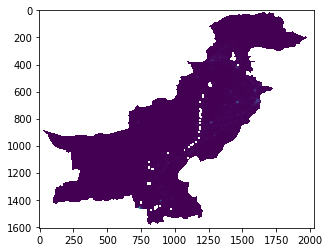

In [550]:
plt.imshow(pop_data)

In [560]:
pop_data.min()

nan

In [561]:
weights = pop_data/pop_sum_array

In [562]:
weights

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [563]:
pop_sum_array.shape

(1608, 2033)

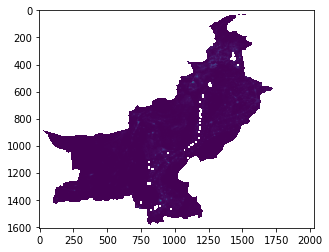

In [565]:
plt.imshow(weights)

In [566]:
zs_sum_weights = pd.DataFrame(zonal_stats(inB2, weights, affine=pop_raster.transform, stats='sum', nodata=np.nan))

In [568]:
inG_data = inG.read(1, masked=False) * 1000
# Correct no data values
# inG_data[inG_data < 0] = 99999999

In [569]:
inG_data.shape

(1608, 2033)

In [570]:
inG_data[inG_data < 0] = np.nan

In [571]:
inG_data.max()

nan

In [572]:
data_weighted = weights*inG_data

In [573]:
zs_weighted = pd.DataFrame(zonal_stats(inB2, data_weighted, affine=inG.transform, stats='sum', nodata=np.nan)).rename(columns={'sum':'pop weighted average travel time'})

In [574]:
zs_weighted.max()

pop weighted average travel time    83.309463
dtype: float64

In [581]:
tt_table = inB2[['Province', 'District']].join(zs_avg).join(zs_weighted)

In [582]:
tt_table.to_csv(os.path.join(out_folder, "Average Travel Time.csv"), index=False)